<a href="https://colab.research.google.com/github/animesharma3/Spam-Detector-BERT-Pytorch-Transformers-Hugging-Face-NLP-State-of-the-Art-Model./blob/main/Spam_Detector_%7C_BERT_%7C_Pytorch_%7C_Transformers_%7C_Hugging_Face_%7C_NLP_%7C_State_of_the_Art_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing and Importing Dependencies

In [5]:
!pip install transformers
# !pip install kashgari


Looking in indexes: https://pypi.org/simple, https://packagecloud.io/github/git-lfs/pypi/simple


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup


from transformers import BertModel, BertForMaskedLM

# import kashgari
from transformers import BertModel, modeling_bert


import warnings
warnings.filterwarnings('ignore')


ModuleNotFoundError: No module named 'transformers.modeling_bert'

# Setting Variables

In [ ]:
PRE_TRAINED_MODEL_NAME = 'prajjwal1/bert-tiny'
device = 'cuda'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
EPOCHS=10
MAX_LEN=512
BATCH_SIZE=16


# Reading and Preprocessing Data

In [ ]:
# df = pd.read_csv('https://raw.githubusercontent.com/animesharma3/SPAM-SMS-Detection/master/spam_sms_collection.csv')[['msg', 'spam']]
df = pd.read_csv('../train.csv')[['Tweet', 'Type']]
df['msg'] = df['Tweet']
df['spam'] = (1 * (df['Type'] == 'Quality'))
# df.drop('Tweet')
# df.drop('Type')
df.head()

,Tweet,Type,msg,spam
0,It's the everything else that's complicated. #...,Quality,It's the everything else that's complicated. #...,1
1,Eren sent a glare towards Mikasa then nodded a...,Quality,Eren sent a glare towards Mikasa then nodded a...,1
2,I posted a new photo to Facebook http://fb.me/...,Quality,I posted a new photo to Facebook http://fb.me/...,1
3,#jan Idiot Chelsea Handler Diagnoses Trump Wit...,Spam,#jan Idiot Chelsea Handler Diagnoses Trump Wit...,0
4,Pedophile Anthony Weiner is TERRIFIED of Getti...,Spam,Pedophile Anthony Weiner is TERRIFIED of Getti...,0


In [ ]:
df.shape

(11968, 4)

In [ ]:
class SpamDataset(Dataset):
    def __init__(self, spam, msgs, tokenizer, max_len):
        self.msgs = msgs
        self.spam = spam
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.msgs)

    def __getitem__(self, i):
        msg = str(self.msgs[i])
        spam = self.spam[i]

        encoding = self.tokenizer.encode_plus(
            msg, 
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'msg': msg,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'spam': torch.tensor(spam, dtype=torch.long)
        }

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = SpamDataset(
        spam=df['spam'].to_numpy(),
        msgs=df['msg'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )

In [ ]:
df_train, df_test = tts(
    df,
    test_size=0.2,
    random_state=42,
    shuffle=True,
)
df_val, _ = tts(
    df,
    test_size=0.5,
    random_state=42,
    shuffle=True,
)
df_train.shape, df_test.shape, df_val.shape


((9574, 4), (2394, 4), (5984, 4))

In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
d = next(iter(train_data_loader))
d.keys()

tensor([[  101,  2023,  2001,  ...,     0,     0,     0],
        [  101,  5245,  2373,  ...,     0,     0,     0],
        [  101,  6350,  6265,  ...,     0,     0,     0],
        ...,
        [  101,  1000, 10558,  ...,     0,     0,     0],
        [  101,  1001,  4862,  ...,     0,     0,     0],
        [  101,  3087,  2040,  ...,     0,     0,     0]])

In [ ]:
d['input_ids'].shape, d['attention_mask'].shape, d['spam'].shape

(torch.Size([16, 512]), torch.Size([16, 512]), torch.Size([16]))

# Model Building

In [ ]:
class SpamClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SpamClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )[1]
        output = self.drop(pooled_output)
        return self.out(output)

In [ ]:
model = SpamClassifier(n_classes=2)
model = model.to(device)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Loss, Optimizer and Scheduler

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
# input_ids = d['input_ids'].to(device)
# attention_mask = d['attention_mask'].to(device)
# targets = d['spam'].to(device)

# outputs = model(
#     input_ids=input_ids,
#     attention_mask=attention_mask
# )
# loss = loss_fn(outputs, targets)
# loss

# Train Model Function

In [ ]:
def train(
    model,
    loss_fn,
    optimizer,
    scheduler,
    device,
    data_loader,
    n_examples
):
    model = model.train() # Setting Model in training mode

    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d['input_ids'].to(device) # [16, 512]
        attention_mask = d['attention_mask'].to(device) # [16, 512]
        targets = d['spam'].to(device) # [16]

        # Forward Propogation
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        ) # [16, 3]

        # Calculating Loss
        loss = loss_fn(outputs, targets)

        _, preds = torch.max(outputs, dim=1)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # Backward Propogation
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Clipping Gradient (Exploding Gradient Problem)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad() # Resetting gradients

    train_acc = correct_predictions.double() / n_examples
    train_loss = np.mean(losses)
    
    return train_acc, train_loss

# Validating Model Function

In [ ]:
def evaluate_model(
    model,
    loss_fn,
    device,
    data_loader,
    n_examples   
):
    model = model.eval() # Setting Model in evaluation mode

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device) # [16, 512]
            attention_mask = d['attention_mask'].to(device) # [16, 512]
            targets = d['spam'].to(device) # [16]

            # Forward Propogation
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            ) # [16, 3]

            # Calculating Loss
            loss = loss_fn(outputs, targets)

            _, preds = torch.max(outputs, dim=1)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
        
    train_acc = correct_predictions.double() / n_examples
    train_loss = np.mean(losses)

    return train_acc, train_loss

# Training the Model

In [ ]:
%%time


history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train(
        model,
        loss_fn,
        optimizer,
        scheduler,
        device,
        train_data_loader,
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = evaluate_model(
        model,
        loss_fn,
        device,
        val_data_loader,
        len(df_val)
    )

    print(f'Validation loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc


Epoch 1/10
----------
Train loss 0.24208661729473005 accuracy 0.9047420096093587
Validation loss 0.13304482860724756 accuracy 0.9527072192513368

Epoch 2/10
----------
Train loss 0.14092552189354493 accuracy 0.9512220597451431
Validation loss 0.11011803829494644 accuracy 0.9637366310160427

Epoch 3/10
----------
Train loss 0.12389330522706095 accuracy 0.9602047211196991
Validation loss 0.10895589119157091 accuracy 0.9662433155080213

Epoch 4/10
----------
Train loss 0.10746195179002922 accuracy 0.9677250887821182
Validation loss 0.09631916875378253 accuracy 0.9715909090909091

Epoch 5/10
----------
Train loss 0.10598260852257925 accuracy 0.9668894923751827
Validation loss 0.08711809549778875 accuracy 0.9737633689839572

Epoch 6/10
----------
Train loss 0.09512658159206551 accuracy 0.9702318780029245
Validation loss 0.0831617231897569 accuracy 0.976437165775401

Epoch 7/10
----------
Train loss 0.09139271612156288 accuracy 0.9731564654271986
Validation loss 0.07747848740409073 accuracy 

# Evaluating the Model Performance

In [ ]:
test_acc, _ = evaluate_model(
    model,
    loss_fn,
    device,
    test_data_loader,
    len(df_test)
)
test_acc.item()

0.9603174603174602

(0.0, 1.0)

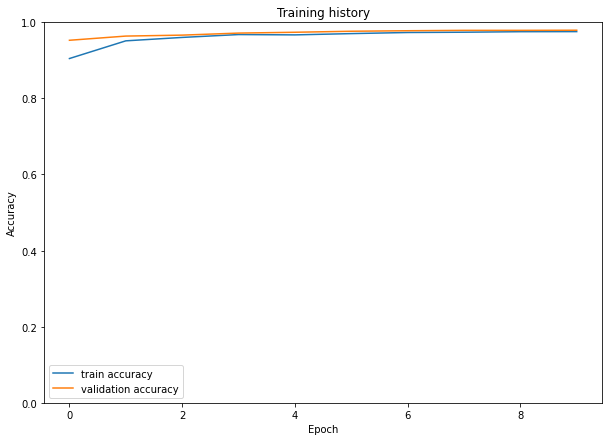

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

In [ ]:
def get_predictions(
    model, data_loader
):
    model = model.eval()

    msgs = []
    predictions = []
    predictions_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            msg = d['msg']
            input_ids = d['input_ids'].to(device)
            attention_masks = d['attention_mask'].to(device)
            spam = d['spam'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_masks
            )

            _, preds = torch.max(outputs, dim=1)

            probs = torch.nn.functional.softmax(outputs, dim=1)

            msgs.extend(msg)
            predictions.extend(preds)
            predictions_probs.extend(probs)
            real_values.extend(spam)
    predictions = torch.stack(predictions).cpu()
    predictions_probs = torch.stack(predictions_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return msgs, predictions, predictions_probs, real_values

In [ ]:
y_msgs, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

# Creating Final Classification Report

In [ ]:
def create_classification_report(Y_test, Y_pred):
    print('--------Classification Report---------\n')
    accuracy = accuracy_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    roc_auc = roc_auc_score(Y_test, Y_pred)
    metrices = [accuracy, f1, precision, recall, roc_auc]
    scores = pd.DataFrame(pd.Series(metrices).values, index=['accuracy', 'f1-score', 'precision', 'recall', 'roc auc score'], columns=['score'])
    print(scores)
    print('\n--------Plotting Confusion Matrix---------')
    sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, cmap='RdYlGn_r', annot_kws={'size': 16})
    return scores

--------Classification Report---------

                  score
accuracy       0.960317
f1-score       0.960433
precision      0.958437
recall         0.962437
roc auc score  0.960316

--------Plotting Confusion Matrix---------


,score
accuracy,0.960317
f1-score,0.960433
precision,0.958437
recall,0.962437
roc auc score,0.960316


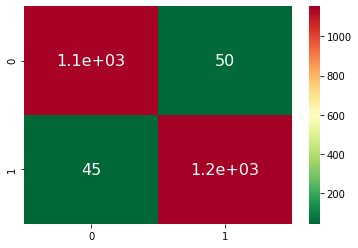

In [ ]:
create_classification_report(y_test, y_pred)

In [ ]:
torch.save(model, 'bert.pt')
